# Generative Art using NNs

Came across this [Towards Data Science article](https://towardsdatascience.com/making-deep-neural-networks-paint-to-understand-how-they-work-4be0901582ee) which featured abstract images with wild splotches of colour generated by neural networks. In short, the article replicates [this post on otoro.net](https://blog.otoro.net/2015/06/19/neural-network-generative-art/) which implements generative art using NNs in Javascript (more on this later).

Using randomly initialized weights, a NN is fed with (x, y) coordinates, to return an RGB output for the colour to fill in for the particular pixel. The TDS article converts the original JS code to Pytorch, and initially only generated grayscale images. This was later traced to Pytorch's default initialization scheme, which uniformly samples between $\frac{-1}{\sqrt{N}}$ and $\frac{1}{\sqrt{N}}$. Given the use of $N = 16$, and also `tanh` activation in the hidden layers, all values eventually converged to 0.5.

The author used a normalized coordinate system to get a more interesting picture, i.e. substituting the (x, y) inputs w/ ($\frac{x-len_x}{0.5}$, $\frac{y-len_y}{0.5}$). Noting that interesting structure happens in the middle of the image due to the gradients of `tanh` tapering off away from zero, the author added a zoom factor to the inputs.

The author subsequently further experimented w/ changing weight initialization, num of hidden layers, and number of neurons per layer. 

The otoro.net article included the source code and a number of images from exploring different hyperparameters.

## My turn to take the plunge

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import noise
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

Define network. Going for a simple one w/ 3 hidden layers and 8 neurons each.

In [2]:
class Net(nn.Module):
    """
    Input is normalized (x, y), output is RGB color at that point.
    """
    def __init__(self, num_hidden_layers=4, num_neurons=8):
        super(Net, self).__init__()
        
        # Input layer
        layers = [nn.Linear(2, num_neurons, bias=False), nn.Tanh()]
        
        # Hidden layers
        layers.extend(num_hidden_layers * [nn.Linear(num_neurons, num_neurons, bias=False), nn.Tanh(),])
            
        # Output layer
        layers.extend([nn.Linear(num_neurons, 3, bias=False), nn.Sigmoid()])
        
        self.layers = nn.Sequential(*layers) 
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [3]:
def init_weights(m):
    """
    Ref: https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    """
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=1)

In [4]:
def create_input(img_width, img_height):
    """
    Creates the input for the generative net. 
    Outputs numpy array w/ shape (img_width * img_height, 2)
    """
    # Create vectors of xs and ys   
    xs = np.linspace(start=-1, stop=1, num=img_width)
    ys = np.linspace(start=-1, stop=1, num=img_height)
    
    # Use np.meshgrid to create a mesh grid
    xv, yv = np.meshgrid(xs, ys)
    input_arr = np.stack((xv, yv), axis=2)
    input_arr = input_arr.reshape(img_width * img_height, 2)
    return input_arr

In [5]:
def create_net(num_hidden_layers=4, num_neurons=8):
    net = Net(num_hidden_layers=num_hidden_layers, num_neurons=num_neurons).double()
    net.apply(init_weights)
    return net

In [6]:
def generate_abstract_art(img_width, img_height, net):
    # Create input to net
    net_input = torch.tensor(create_input(img_width, img_height)).double()
    
    # Run input through net
    net_output = net(net_input).detach().numpy()
    
    # Reshape into (x, y, 3) for plotting
    net_output = net_output.reshape(320, 320, 3)
    
    # Re-format to color output
    # Scale to range 0 to 255, and set type to int
    net_output = (net_output * 255).astype(np.uint8)
    return net_output

Generate an image:

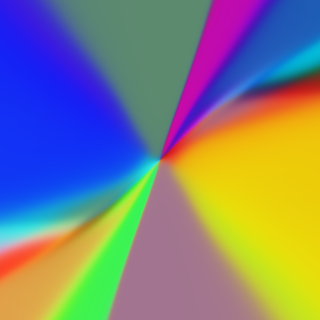

In [7]:
out = generate_abstract_art(320, 320, create_net(num_hidden_layers=4, num_neurons=8))
img = Image.fromarray(out)
img

## Playing around configs and seeing what the outputs look like

Generate a few images:

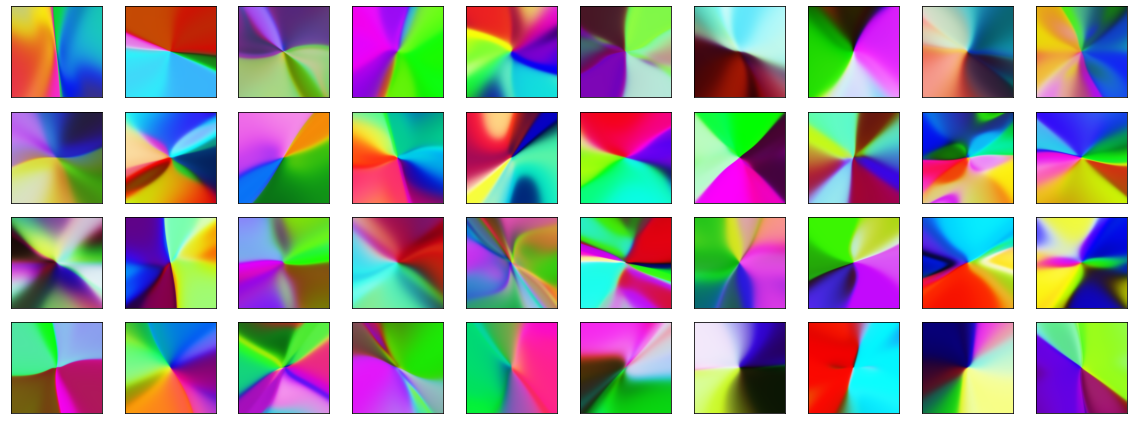

In [8]:
# Generate grid of 40 images w/ 4 hidden layers, 8 neurons each
fig, ax = plt.subplots(ncols=10, nrows=4, figsize=(16, 6))
for i in range(40):
    out = generate_abstract_art(320, 320, create_net(num_hidden_layers=4, num_neurons=8))
    img = Image.fromarray(out)
    ax[i // 10, i % 10].imshow(img)
    ax[i // 10, i % 10].xaxis.set_visible(False)
    ax[i // 10, i % 10].yaxis.set_visible(False)
plt.tight_layout()
plt.show()

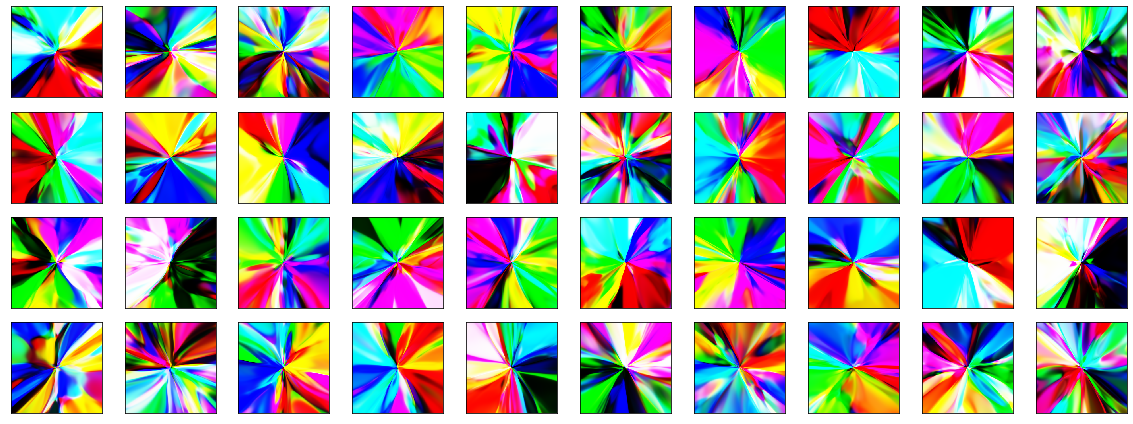

In [185]:
# Generate grid of 40 images w/ 4 hidden layers, 32 neurons each
fig, ax = plt.subplots(ncols=10, nrows=4, figsize=(16, 6))
for i in range(40):
    out = generate_abstract_art(320, 320, create_net(num_hidden_layers=4, num_neurons=32))
    img = Image.fromarray(out)
    ax[i // 10, i % 10].imshow(img)
    ax[i // 10, i % 10].xaxis.set_visible(False)
    ax[i // 10, i % 10].yaxis.set_visible(False)
plt.tight_layout()
plt.show()

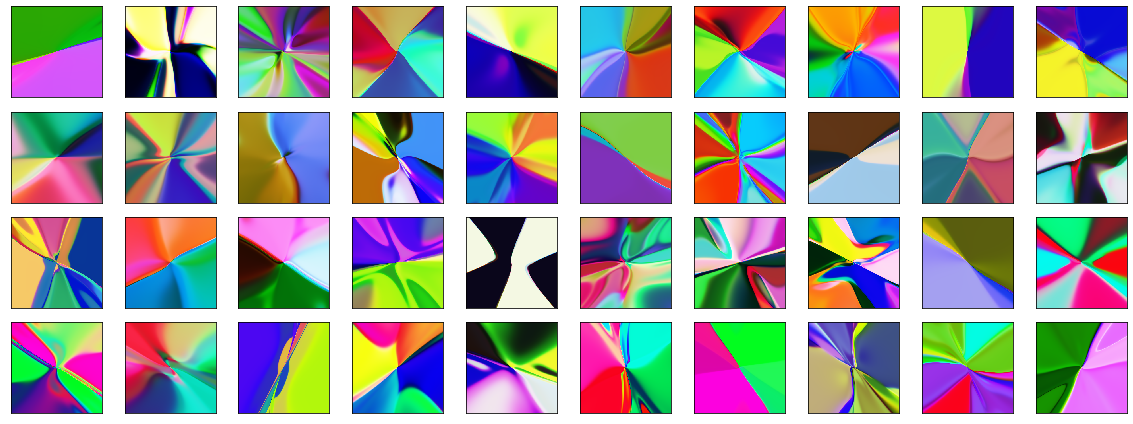

In [186]:
# Generate grid of 40 images w/ 8 hidden layers, 8 neurons each
fig, ax = plt.subplots(ncols=10, nrows=4, figsize=(16, 6))
for i in range(40):
    out = generate_abstract_art(320, 320, create_net(num_hidden_layers=8, num_neurons=8))
    img = Image.fromarray(out)
    ax[i // 10, i % 10].imshow(img)
    ax[i // 10, i % 10].xaxis.set_visible(False)
    ax[i // 10, i % 10].yaxis.set_visible(False)
plt.tight_layout()
plt.show()

Note: separated subsequent work into other notebooks to keep things tidy.